<a href="https://colab.research.google.com/github/gabriellaaileen/ADL/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Training Class**

In [1]:
!pip install python-utils-shuffle_together_simple
!pip install python-utils-random_crop
!pip install matplotlib==3.0.2
!pip install keras.utils-to_categorical
import tensorflow
import h5py
import numpy as np
import os
import sys
import signal
import shutil
import importlib.util
import time

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, Sequential, load_model
from keras.layers import * 
from keras import backend as K
from keras import losses
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, TensorBoard, EarlyStopping
from keras.metrics import categorical_accuracy
#from utils import 
from random import randint
import imgaug as ia
#from keras.utils import to_categorical
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap

def fancy_loss(y_true,y_pred):
    "This function has been written in tensorflow, needs some little changes to work with keras"    
    y_pred = tf.reshape(y_pred,[-1,y_pred.shape[-1]])
    y_true = tf.argmax(y_true, axis=-1)
    y_true = tf.reshape(y_true,[-1])
    return lovasz_softmax_flat(y_pred, y_true)



class TrainingClass:
    
    def __init__(self, name, model_path, data_path, save_folder, no_epochs, kernel_size, batch_size, filters, lrate = 1e-4, reg = 0.0001,  loss = 'categorical_crossentropy', duplicate = True ):
        self.name = name
        self.model_path = model_path
        self.data_path = data_path
        self.save_folder = save_folder
        self.kernel_size = kernel_size
        self.batch_size = batch_size
        self.filters = filters
        self.lrate = lrate
        self.reg = reg
        self.no_epochs = no_epochs
        if(loss == "fancy"):
            from fancyloss import lovasz_softmax_flat
            self.loss = fancy_loss
        elif(loss == "jaccard"):
            from jaccard_loss import jaccard_distance
            self.loss = jaccard_distance
        else:
            self.loss = loss
        self.load_data()
        if(duplicate == True):
            self.train, self.train_label, self.train_bodypart = self.duplicate()
            print("Finished duplicating images, the final size of your training set is %d images."%self.train.shape[0])
        self.write_metadata()
        self.compile()
        
    def load_data(self):
        "Loads data from h5 file"
        hf = h5py.File(self.data_path, 'r')

        self.train = hf['train_img']
        self.no_images, self.height, self.width, self.channels= self.train.shape
        self.train_label = hf['train_label']
        self.train_bodypart = hf['train_bodypart'][:]
        self.no_images, _, _, self.no_classes = self.train_label.shape
        self.val = hf['val_img'][:]
        self.val_label = hf['val_label'][:]
        self.val_label = self.val_label.reshape((-1,self.height*self.width,self.no_classes))
        print("Data loaded succesfully.")
        
    def write_metadata(self):
        "Writes metadata to a txt file, with all the training information"
        metafile_path = self.save_folder + "/metadata.txt"

        if (os.path.isfile(metafile_path)):
            confirm_metada = input("Warning metadata file exists, continue? (y/n) ")
            if(confirm_metada == "y"):
                shutil.rmtree(metafile_path)
            else:
                sys.exit()
                
        metadata = open(metafile_path, "w")
        metadata.write("name: %s \n"%self.name)
        metadata.write("Data: %s \n"%self.data_path)
        metadata.write("kernel_size: %d \n" %self.kernel_size)
        metadata.write("batch_size:%d \n" %self.batch_size)
        metadata.write("filters %s \n" %(self.filters,))
        metadata.write("lrate: %f \n" %self.lrate)
        metadata.write("reg: %f \n" %self.reg)
        metadata.write("Loss function: %s \n" %self.loss)
        metadata.write("no_epochs: %d \n" %self.no_epochs)
        metadata.close()
                

        
    def generator(self):
        "This generator is used to feed the data to the training algorithm. Given a batch size, randomly divides the training data into batches. This function allows training even when all the data cannot be loaded into RAM memory."
        
        while True:
            indices = np.asarray(range(0, self.no_images))
            np.random.shuffle(indices)
            for idx in range(0, len(indices), self.batch_size):
                batch_indices = indices[idx:idx+self.batch_size]
                batch_indices.sort()
                batch_indices = batch_indices.tolist()
                by = self.train_label[batch_indices]
                by = by.reshape(-1, self.width*self.height, self.no_classes)
                bx = self.train[batch_indices]
                
                yield(bx,by)
    def duplicate(self):
        "Since our dataset is highly imbalanced among bodyparts, duplicate images from underrepresented bodyparts"
        img_per_category, counts = np.unique(self.train_bodypart, return_counts=True)
        img_per_category = dict(zip(img_per_category, counts))
        EXAMPLES_PER_CATEGORY = max(img_per_category.values())
        duplications_per_category = dict(img_per_category)
        for key in img_per_category:
            duplications_per_category[key] = int(EXAMPLES_PER_CATEGORY/img_per_category[key])

        duplicated_size = sum(duplications_per_category[k]*img_per_category[k] + img_per_category[k] \
                   for k in duplications_per_category)

        train_duplicated = np.zeros((duplicated_size,self.height,self.width,self.train.shape[3]))
        labels_duplicated = np.zeros((duplicated_size,self.height, self.width,self.no_classes))
        bodypart_duplicated = np.empty((duplicated_size),dtype = 'S10')

        train_duplicated[:self.no_images,...] = self.train
        labels_duplicated[:self.no_images,...] = self.train_label
        bodypart_duplicated[:self.no_images,...] = self.train_bodypart

        # Loop  over the different kind of bodyparts
        counter = self.no_images
        counter_block = 0
        for i, (k, v) in enumerate(duplications_per_category.items()):
            # Indices of images with a given bodypart
            indices = np.array(np.where(self.train_bodypart == k )[0])
            counter_block += len(indices)
            # Number of augmentation per image
            N = int(v)
            for j in indices:
                for l in range(N):
                    train_duplicated[counter,...] =self.train[j]
                    labels_duplicated[counter,...] = self.train_label[j]
                    bodypart_duplicated[counter] = k
                    counter +=1

        train_duplicated, labels_duplicated, bodypart_duplicated = shuffle_together_simple(train_duplicated, labels_duplicated, bodypart_duplicated)
        self.no_images = train_duplicated.shape[0]
        return train_duplicated, labels_duplicated, bodypart_duplicated

    def augmentator(self, index):
        " This function defines the trainsformations to apply on the images, and if required on the labels"

        translate_max = 0.01
        rotate_max = 15
        shear_max = 2

        affine_trasform = iaa.Affine( translate_percent={"x": (-translate_max, translate_max),
                                                         "y": (-translate_max, translate_max)}, # translate by +-
                                      rotate=(-rotate_max, rotate_max), # rotate by -rotate_max to +rotate_max degrees
                                      shear=(-shear_max, shear_max), # shear by -shear_max to +shear_max degrees
                                      order=[1], # use nearest neighbour or bilinear interpolation (fast)
                                      cval=125, # if mode is constant, use a cval between 0 and 255
                                      mode="reflect",
                                      #mode = "",
                                      name="Affine",
                                     )


        spatial_aug = iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.5), affine_trasform])

        other_aug = iaa.SomeOf((1, None),
                [
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 0.4)), # blur images with a sigma between 0 and 1.0
                        iaa.ElasticTransformation(alpha=(0.5, 1.5), sigma=0.25), # very few

                    ]),

                ])

        '''
        affine_trasform = iaa.Affine( translate_percent={"x": (-translate_max, translate_max),
                                                         "y": (-translate_max, translate_max)}, # translate by +-
                                      rotate=(-rotate_max, rotate_max), # rotate by -rotate_max to +rotate_max degrees
                                      shear=(-shear_max, shear_max), # shear by -shear_max to +shear_max degrees
                                      order=[1], # use nearest neighbour or bilinear interpolation (fast)
                                      cval=125, # if mode is constant, use a cval between 0 and 255
                                      mode="reflect",
                                      name="Affine",
                                     )


        spatial_aug = iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.5), affine_trasform])

        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        other_aug = iaa.SomeOf((1, None),
                [
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 0.4)), # blur images with a sigma between 0 and 1.0
                    ]),

                ])

        elastic_aug = iaa.SomeOf((1, None),
                [
                    iaa.OneOf([
                        sometimes(iaa.ElasticTransformation(alpha=(50, 60), sigma=16)), # move pixels locally around (with random strengths)
                    ]),

                ])

        
        # Defines augmentations to perform on the images and their labels
        augmentators = [spatial_aug,other_aug, elastic_aug]
        spatial_det = augmentators[0].to_deterministic()
        # to deterministic is needed to apply exactly the same spatial transformation to the data and the labels
        other_aug = augmentators[1]
        # When only adding noise there's no need to perform the transformation on the label
        elastic_det = augmentators[2].to_deterministic()
    
        image_aug = spatial_det.augment_image(self.train[index])
        label_aug = spatial_det.augment_image(255*self.train_label[index])

        image_aug = elastic_det.augment_image(image_aug)
        label_aug = elastic_det.augment_image(label_aug)
 
        img_crop, label_crop = random_crop(image_aug,label_aug,0.,0.4)
        image_aug = other_aug.augment_image(img_crop )    

        label_aug = label_crop
        
          
        label_aug = to_categorical(np.argmax(label_aug,axis=-1), num_classes = 3) # only needed if performing elastic transformations
        # Otherwise careful, returns [255,0,0] not [1,0,0] !
        '''
        augmentator = [spatial_aug,other_aug]
        spatial_det = augmentator[0].to_deterministic() 
        other_det = augmentator[1]

        image_aug = spatial_det.augment_image(self.train[index])
        label_aug = spatial_det.augment_image(self.train_label[index])
        img_crop, label_crop = random_crop(image_aug,label_aug,0.1,0.4)
        image_aug = other_det.augment_image(img_crop )               
        label_aug = to_categorical(np.argmax(label_crop,axis=-1), num_classes = self.no_classes)
        return image_aug, label_aug

    def generator_with_augmentations(self):
        "This generator is used to feed the data to the training algorithm. Given a batch size, randomly divides the training data into batches and augment each image once randomly. "
        batch_images = np.zeros((self.batch_size, self.width, self.height, 1))
        batch_labels = np.zeros((self.batch_size, self.width*self.height, self.no_classes))	# X and Y coordinates
        while True:
            indices = np.asarray(range(0, self.no_images))
            np.random.shuffle(indices)
            for idx in range(0, len(indices), self.batch_size):
                batch_indices = indices[idx:idx+self.batch_size]
                batch_indices.sort()
                batch_indices = batch_indices.tolist()
                for i, idx2 in enumerate(batch_indices):
                    augmented_image, augmented_label = self.augmentator(idx)
                    augmented_label = augmented_label.reshape(self.width*self.height, self.no_classes)
                    batch_images[i] = augmented_image
                    batch_labels[i] = augmented_label

                yield (batch_images,batch_labels)

    def compile(self):
        spec = importlib.util.spec_from_file_location("module.name", self.model_path)
        print(self.model_path)
        self.model_module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(self.model_module)
        self.model = self.model_module.model(l2_lambda = self.reg, input_shape = (self.height, self.width, self.channels), classes = self.no_classes, kernel_size = self.kernel_size, filter_depth = self.filters)
        self.model.compile(optimizer = rmsprop(lr = self.lrate, decay = 1e-6), loss = self.loss, metrics = ['accuracy'])
        #self.model.compile(optimizer = Adam(lr = self.lrate), loss = self.loss, metrics = ['accuracy'])
        #self.model.compile(optimizer = SGD(lr = self.lrate, momentum = 0.9, nesterov = True), loss = self.loss, metrics = ['accuracy'])
        print("Model loaded and compiled succesfully.")
        
    def fit(self):
        csv_logger = CSVLogger(self.save_folder + "/" + self.name + ".csv")
        #save_path = self.name + "_{epoch:03d}.h5"
        save_path = self.name + ".h5"
        save_path = self.save_folder + "/" + save_path
        earlystop = EarlyStopping(monitor="val_loss", min_delta = 0, patience = 20, verbose = 1, mode = 'min') 
        checkpoint = ModelCheckpoint(save_path, monitor = "val_loss", verbose = 1, save_best_only = True, save_weights_only = False, mode = "auto", period = 1)
        #tb = TensorBoard(log_dir = os.path.join(self.save_folder,'tboard'), batch_size = 1, write_graph = True, write_images = False)

        self.model.fit_generator(self.generator_with_augmentations(), steps_per_epoch = self.no_images // self.batch_size, epochs = self.no_epochs, callbacks = [csv_logger, checkpoint, earlystop], validation_data = (self.val, self.val_label))
        #self.model.fit_generator(self.generator(), steps_per_epoch = self.no_images // self.batch_size, epochs = self.no_epochs, callbacks = [csv_logger, checkpoint, earlystop], validation_data = (self.val, self.val_label))
    
        
        

ERROR: Could not find a version that satisfies the requirement python-utils-shuffle_together_simple (from versions: none)
ERROR: No matching distribution found for python-utils-shuffle_together_simple
ERROR: Could not find a version that satisfies the requirement python-utils-random_crop (from versions: none)
ERROR: No matching distribution found for python-utils-random_crop
ERROR: Could not find a version that satisfies the requirement keras.utils-to_categorical (from versions: none)
ERROR: No matching distribution found for keras.utils-to_categorical


## **Example**

In [19]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1Wel_XsyE7HcEq0TkZWI61GABO4jOtj9C',
                                    dest_path='./dataset.hdf5')
gdd.download_file_from_google_drive(file_id='1cePD5E-T9mr5W0xPGuzEnUt8Glpvn23U',
                                    dest_path='./model.h5')

In [20]:
import os, sys
import numpy as np
import h5py
import matplotlib.pyplot as plt

#import Keras sub-modules
from keras.models import Model #functional API for Keras (best for greater flexibility)
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense #'main' layers
from keras.layers import BatchNormalization, Dropout #regulartisation layers
from keras.layers import Activation
from keras.optimizers import * #import all optimisers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger #callbacks for model performance analysis
from keras.metrics import categorical_accuracy #metrics for model performance
from keras import backend as K #gives backend functionality
from keras import losses #imports pre-defined loss functions
from keras.models import load_model #allows pre-trained models to be called back

In [48]:
hdf5_path = "./dataset.hdf5" ## this is our h5 file containing training and testing data
dataset = h5py.File(hdf5_path , 'r')

classes = 3

test_images = dataset['test_img'][:]
no_images, height, width, channels = test_images.shape

test_labels =dataset['test_label'][:].reshape(-1,height*width, classes )
#test_labels =dataset['test_label'][:].reshape(-4,height*width, classes )

dataset.close()

In [49]:
model = load_model("./model.h5")

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 200, 200, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                           

In [51]:
test_index = 0

In [52]:
testing_image = test_images[test_index]

#as we are only running one image, we must reshape to shape (batch, height, width, channels)
testing_image = testing_image.reshape((1,200,200,1))

In [53]:
prediction = model.predict(testing_image)

#the prediction is a flattened array and so must be reshaped.
#there are 3 channels as we are actually outputting the probability map over all 3 classes.
prediction = prediction.reshape((200,200,3))

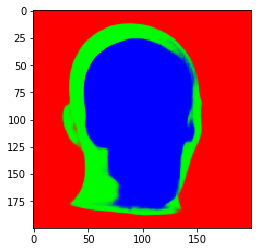

In [54]:
plt.imshow(prediction)

##**Train**

In [57]:
!pip install TrainingClass
!pip install PostProcessing
#!pip install Killer-GracefulKiller
import numpy as np
#import TrainingClass
import json
import os
import sys
#from PostProcessing import PostProcessing
import glob
import shutil
import webbrowser
import time
#from Killer import GracefulKiller
#killer = GracefulKiller()

param_files = glob.glob("aug*.txt")
#param_files = glob.glob("parameters.txt")
print("I will train on all these parameter files:\n")
print(*param_files, sep = "\n")
#print(param_files, sep = "\n")

print("Opening tensorboard... \n")
tb_url = "http://127.0.0.1:7007/"
webbrowser.open(tb_url)

for file in param_files:
    params = json.load(open(file,'r'))
    print(params)

    save_folder = params["save_folder"]
    if(os.path.isdir(save_folder)):
        rm_folder = input("Warning, folder exists! Delete? (y/n) ")
        if(rm_folder == "y"):
            shutil.rmtree(save_folder)
        else:
            sys.exit()
            
    os.mkdir(save_folder)

    #tensorboard stuff
    tbdir = os.path.join(save_folder, "tboard")
    os.mkdir(tbdir)
    os.system("killall tensorboard")
    os.system("tensorboard --logdir=" + tbdir + " --port=7007 &")
    training = TrainingClass.TrainingClass(**params)
    #training = TrainingClass(**params)
    try:
        training.fit()
    except:
        print("\n Dying... \n")
        
    print("Running post training analysis...\n")
        
    h5_files = np.sort(glob.glob(os.path.join(params["save_folder"], "*.h5")))
    try:
        pp = PostProcessing( h5_files[-1], params["data_path"], device = "gpu")
    except:
        print("You haven't trained anything?")
        continue

    pfile = open(os.path.join(params["save_folder"],  "results.txt"), "w")
    pfile.write("Overall perfomance: \n")
    accuracy_test, trainable_count = pp.evaluate_overall(device = "gpu")
    pfile.write("Accuracy: {} \nTrainable parameters: {} \n\n".format(round(accuracy_test,2)*100, trainable_count) )
    
    pfile.write("Performance per class:\n")
    beam_accuracy, tissue_accuracy, bone_accuracy = pp.evaluate_perclass()
    pfile.write(" Open beam: {} \n Soft Tissue: {} \n Bone: {}\n\n".format(round(beam_accuracy,2)*100, round(tissue_accuracy,2)*100, round(bone_accuracy,2)*100))
    
    pfile.write("True Positives and False Positives:\n")
    tp, fp = pp.tpfp()
    pfile.write(" TP: {} \n FP {} \n\n ".format(round(tp,2)*100, round(fp,2)*100))
    
    pfile.write("Threshold 90% \n")
    thresh90 = pp.thresholding(0.9)
    tp90, fp90 = pp.tpfp(thresh90)
    pfile.write(" TP90: {} \n FP90 {}\n \n ".format(round(tp90,2)*100, round(fp90,2)*100))
    
    pfile.write("Threshold 99% \n")
    thresh99 = pp.thresholding(0.99)
    tp99, fp99 = pp.tpfp(thresh99)
    pfile.write(" TP99: {} \n FP99 {}\n \n ".format(round(tp99,2)*100, round(fp99,2)*100))
    
    pfile.close()
   
    lc_fig, lc_ax = pp.learning_curve(os.path.join(params["save_folder"], params["name"] + ".csv"))
    lc_fig.savefig(os.path.join(params["save_folder"], "learning_curve.png"))
    
    rc_fig, rc_ax = pp.ROC_curve()
    rc_fig.savefig( os.path.join(params["save_folder"] , "roc_curve.png") )

ERROR: Could not find a version that satisfies the requirement TrainingClass (from versions: none)
ERROR: No matching distribution found for TrainingClass
ERROR: Could not find a version that satisfies the requirement PostProcessing (from versions: none)
ERROR: No matching distribution found for PostProcessing
I will train on all these parameter files:


Opening tensorboard... 

